In [79]:
import os
os.listdir()

['.ipynb_checkpoints',
 'Crop_Production_Prediction.ipynb',
 'datasets',
 'Project4_Crop Production In India.docx']

In [80]:
os.listdir("datasets")

['.ipynb_checkpoints',
 'agriculture_production_index.csv.csv',
 'crop_area_production_yield_wide.csv.csv',
 'crop_cost_yield.csv',
 'crop_metadata.csv',
 'crop_production_timeseries_india.csv']

In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

print("Libraries imported successfully")

Libraries imported successfully


In [82]:
import pandas as pd

df = pd.read_csv("datasets/crop_cost_yield.csv")
df.head()

,Crop,State,Cost of Cultivation (`/Hectare) A2+FL,Cost of Cultivation (`/Hectare) C2,Cost of Production (`/Quintal) C2,Yield (Quintal/ Hectare)
0,ARHAR,Uttar Pradesh,9794.05,23076.74,1941.55,9.83
1,ARHAR,Karnataka,10593.15,16528.68,2172.46,7.47
2,ARHAR,Gujarat,13468.82,19551.90,1898.30,9.59
3,ARHAR,Andhra Pradesh,17051.66,24171.65,3670.54,6.42
4,ARHAR,Maharashtra,17130.55,25270.26,2775.80,8.72


In [83]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Crop                                   49 non-null     object 
 1   State                                  49 non-null     object 
 2   Cost of Cultivation (`/Hectare) A2+FL  49 non-null     float64
 3   Cost of Cultivation (`/Hectare) C2     49 non-null     float64
 4   Cost of Production (`/Quintal) C2      49 non-null     float64
 5   Yield (Quintal/ Hectare)               49 non-null     float64
dtypes: float64(4), object(2)
memory usage: 2.4+ KB


(49, 6)

In [84]:
plt.figure(figsize=(6,4))
sns.histplot(df['yield_qtl_per_hectare'], kde=True)
plt.title("Distribution of Crop Yield")
plt.xlabel("Yield (Quintals per Hectare)")
plt.show()

KeyError: 'yield_qtl_per_hectare'

<Figure size 600x400 with 0 Axes>

In [ ]:
#The relationship between cost of cultivation and yield is not strictly linear, indicating the need for non-linear models.
plt.figure(figsize=(10,5))
sns.boxplot(x='crop', y='yield_qtl_per_hectare', data=df)
plt.xticks(rotation=45)
plt.title("Yield Distribution Across Crops")
plt.show()

In [ ]:
#The relationship between cost of cultivation and yield is not strictly linear, indicating the need for non-linear models.
plt.figure(figsize=(10,5))
sns.boxplot(x='state', y='yield_qtl_per_hectare', data=df)
plt.xticks(rotation=45)
plt.title("Yield Distribution Across States")
plt.show()

In [ ]:
#Correlation analysis shows moderate relationships between cost variables and yield, supporting the use of machine learning models.
plt.figure(figsize=(6,4))
sns.heatmap(
    df[['cost_cultivation_a2_fl',
        'cost_cultivation_c2',
        'cost_production',
        'yield_qtl_per_hectare']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation Matrix")
plt.show()

In [85]:
# Rename columns to make them shorter and Python-friendly
df.columns = [
    'crop',
    'state',
    'cost_cultivation_a2_fl',
    'cost_cultivation_c2',
    'cost_production',
    'yield_qtl_per_hectare'
]

# Verify column renaming
df.head()


,crop,state,cost_cultivation_a2_fl,cost_cultivation_c2,cost_production,yield_qtl_per_hectare
0,ARHAR,Uttar Pradesh,9794.05,23076.74,1941.55,9.83
1,ARHAR,Karnataka,10593.15,16528.68,2172.46,7.47
2,ARHAR,Gujarat,13468.82,19551.90,1898.30,9.59
3,ARHAR,Andhra Pradesh,17051.66,24171.65,3670.54,6.42
4,ARHAR,Maharashtra,17130.55,25270.26,2775.80,8.72


In [86]:
# Target variable (what we want to predict)
target = 'yield_qtl_per_hectare'

# Input features used for prediction
features = [
    'crop',
    'state',
    'cost_cultivation_a2_fl',
    'cost_cultivation_c2',
    'cost_production'
]


In [87]:
# Statistical summary of numerical columns
df.describe()

,cost_cultivation_a2_fl,cost_cultivation_c2,cost_production,yield_qtl_per_hectare
count,49.000000,49.000000,49.000000,49.000000
mean,20363.537347,31364.666735,1620.537755,98.086735
std,13561.435306,20095.783569,1104.990472,245.293123
min,5483.540000,7868.640000,85.790000,1.320000
25%,12774.410000,19259.840000,732.620000,9.590000
50%,17022.000000,25909.050000,1595.560000,13.700000
75%,24731.060000,35423.480000,2228.970000,36.610000
max,66335.060000,91442.630000,5777.480000,1015.450000


In [88]:
# Separate input features (X) and target variable (y)
X = df.drop('yield_qtl_per_hectare', axis=1)
y = df['yield_qtl_per_hectare']

In [89]:
# Convert categorical columns (crop, state) into numerical form
X_encoded = pd.get_dummies(X, columns=['crop', 'state'], drop_first=True)

# Check the transformed dataset
X_encoded.head()

,cost_cultivation_a2_fl,cost_cultivation_c2,cost_production,crop_COTTON,crop_GRAM,crop_GROUNDNUT,crop_MAIZE,crop_MOONG,crop_PADDY,crop_RAPESEED AND MUSTARD,...,state_Haryana,state_Karnataka,state_Madhya Pradesh,state_Maharashtra,state_Orissa,state_Punjab,state_Rajasthan,state_Tamil Nadu,state_Uttar Pradesh,state_West Bengal
0,9794.05,23076.74,1941.55,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,10593.15,16528.68,2172.46,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,13468.82,19551.90,1898.30,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,17051.66,24171.65,3670.54,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,17130.55,25270.26,2775.80,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [90]:
# Check number of features after encoding
X_encoded.shape

(49, 24)

In [91]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42
)

In [92]:
X_train.shape, X_test.shape

((39, 24), (10, 24))

In [93]:
# Create Linear Regression model
lr_model = LinearRegression()

In [94]:
# Train the model using training data
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [95]:
# Predict yield for test data
y_pred_lr = lr_model.predict(X_test)

In [96]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_lr)

mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)   # take square root manually

r2 = r2_score(y_test, y_pred_lr)

mae, rmse, r2

# Linear Regression evaluation
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [97]:
# Create Random Forest Regressor model
rf_model = RandomForestRegressor(
    n_estimators=100,      # number of trees
    random_state=42        # reproducibility
)

In [98]:
# Train Random Forest model
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [99]:
# Predict yield using Random Forest
y_pred_rf = rf_model.predict(X_test)

In [100]:
# Evaluate Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

r2_rf = r2_score(y_test, y_pred_rf)

mae_rf, rmse_rf, r2_rf

# Random Forest evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [101]:
comparison = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest"],
    "R2 Score": [r2_lr, r2_rf],
    "RMSE": [rmse_lr, rmse_rf]
})

comparison

,Model,R2 Score,RMSE
0,Linear Regression,0.906583,91.864314
1,Random Forest,0.956688,62.551600


In [102]:
# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values(
    by='Importance', ascending=False
)

# Show top 10 important features
feature_importance.head(10)

,Feature,Importance
10,crop_SUGARCANE,0.369024
2,cost_production,0.358744
1,cost_cultivation_c2,0.167526
0,cost_cultivation_a2_fl,0.087301
22,state_Uttar Pradesh,0.011055
15,state_Karnataka,0.005725
17,state_Maharashtra,0.000317
8,crop_PADDY,0.000193
19,state_Punjab,0.000054
6,crop_MAIZE,0.000025


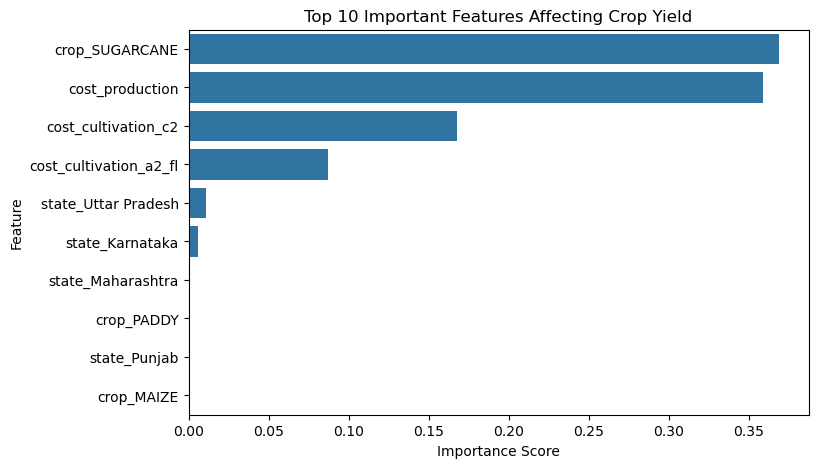

In [103]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=feature_importance.head(10),
    x='Importance',
    y='Feature'
)
plt.title("Top 10 Important Features Affecting Crop Yield")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

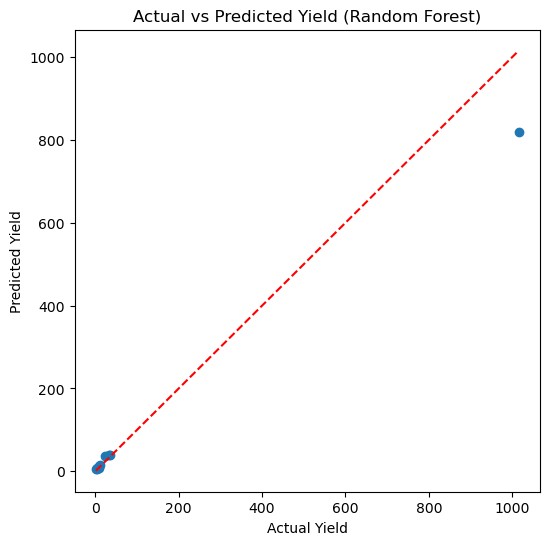

In [104]:
plt.figure(figsize=(6,6))

# Scatter plot
plt.scatter(y_test, y_pred_rf)
y_log = np.log1p(y)
# Ideal prediction line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)

plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield (Random Forest)")
plt.show()